## Neural style transfer

Based on paper: https://arxiv.org/pdf/1508.06576.pdf. More comments see in texture synthesis notebook, which uses the same technique from the same authors.

In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
import torchvision.transforms as TF
from collections import OrderedDict
from PIL import Image
import matplotlib.pyplot as plt
from time import time

In [2]:
def getmodel(required_layers=None):
    m=models.vgg19(pretrained=True).eval().requires_grad_(False).cuda()
    m=next(m.children()) # extract convolutional part
    idxs={}
    mods=[]
    reqs=required_layers.copy() if required_layers else None
    for c in m.children():
        type=c.__class__.__name__.lower().replace('2d','').replace('max','')
        idx=idxs.setdefault(type,0)+1
        idxs[type]=idx
        name='%s%s'%(type,idx)
        mods.append((name,c))
        if reqs is not None:
            if name in reqs:
                reqs.remove(name)
                if not reqs: break
    return nn.Sequential(OrderedDict(mods))

# use print(), otherwise model is not garbage collected
print(getmodel())

Sequential(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU(inplace=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU(inplace=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU(inplace=True)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU(inplace=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu5): ReLU(inplace=True)
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu6): ReLU(inplace=True)
  (conv7): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu7): ReLU(inplace=True)
  (conv8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 

In [3]:
def hookmodel(layers):
    outs=OrderedDict()
    mod2name={}
    def hook(mod,inp,out): outs[mod2name[mod]]=out
    m=getmodel(layers)
    for name,c in m.named_children():
        if name in layers:
            mod2name[c]=name
            c.register_forward_hook(hook)
    return m,outs

In [4]:
style_layers=['pool1','pool2','pool3','pool4']
m,outs=hookmodel(style_layers)

In [36]:
# earlier layers get more priority, i.e. transfer more of low-level features (e.g. strokes)
# rather than higher-level objects
style_weights=torch.tensor([20.,10,5,1])
style_weights=style_weights/style_weights.sum()
style_weights

tensor([0.5556, 0.2778, 0.1389, 0.0278])

In [29]:
def getgrams(x):
    outs.clear()
    m(x) # activations are saved via hooks
    grams=[]
    for feats in outs.values():
        b,c,h,w=feats.shape
        feats=feats.view((b,c,h*w))
        grams.append(feats@feats.transpose(1,2)/(h*w))
    return grams

In this implementation we don't restore content image features, we just transfer style from style image and use content image as a starting point. In his implementation https://github.com/leongatys/PytorchNeuralStyleTransfer/blob/master/NeuralStyleTransfer.ipynb, original author also starts from content image rather than random noise, but nonetheless restores features. I don't see much difference in results.

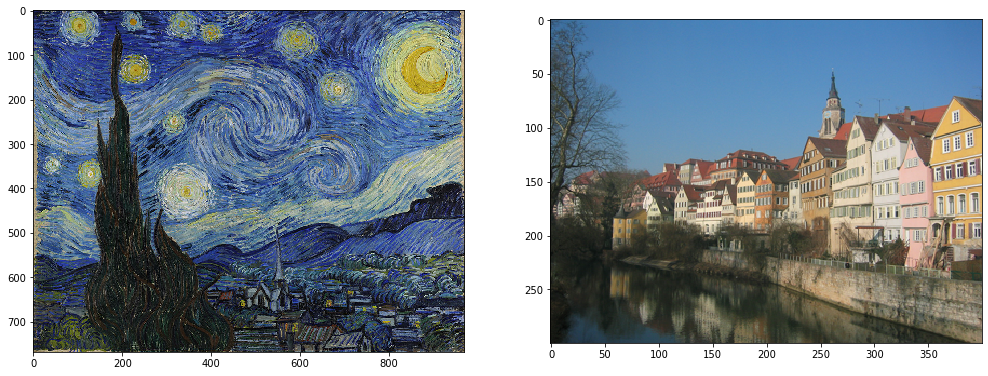

In [60]:
styleim=Image.open('vangogh_starry_night.jpg')
contim=Image.open('Tuebingen_Neckarfront.jpg').resize((400,300))
_,ax=plt.subplots(1,2,figsize=(17,10))
ax[0].imshow(styleim)
ax[1].imshow(contim)

In [49]:
# imagenet stats from https://pytorch.org/docs/1.2.0/torchvision/models.html
means=torch.tensor([0.485,0.456,0.406])
stds=torch.tensor([0.229,0.224,0.225])

prepr=TF.Compose([
    TF.ToTensor(),
    TF.Normalize(means.tolist(),stds.tolist()),
    TF.Lambda(lambda x:x[None].cuda())
])
postp=TF.Compose([
    TF.Lambda(lambda x:x[0].cpu()),
    TF.Normalize((-means/stds).tolist(),(1/stds).tolist()),
    TF.Lambda(lambda x:x.clamp(0,1)),
    TF.ToPILImage()
])

In [50]:
styleimt=prepr(styleim)
styleimt.shape

torch.Size([1, 3, 768, 970])

In [51]:
stylegrams=getgrams(styleimt)
[g.shape for g in stylegrams]

[torch.Size([1, 64, 64]),
 torch.Size([1, 128, 128]),
 torch.Size([1, 256, 256]),
 torch.Size([1, 512, 512])]

In [52]:
def getloss(grams1,grams2):
    return sum(F.mse_loss(g1,g2) for g1,g2 in zip(grams1,grams2))

In [61]:
x=prepr(contim).requires_grad_()

1 139.4127960205078
2 139.3700408935547
3 89.33180236816406
4 79.39242553710938
5 45.283992767333984
6 26.388322830200195
7 27.825891494750977
8 16.457170486450195
9 14.579832077026367
10 13.364233016967773
11 11.61860179901123
12 8.429695129394531
13 6.172557830810547
14 5.586902141571045
15 4.339986324310303
16 4.07757043838501
17 3.6345419883728027
18 3.024174451828003
19 2.803499937057495
20 2.4749510288238525
21 2.191418409347534
22 1.9431225061416626
23 1.7374557256698608
24 1.7010142803192139
25 1.5582809448242188
26 1.4535928964614868
27 1.3473353385925293
28 1.2202558517456055
29 1.1536166667938232
30 1.0987478494644165
31 1.060590386390686
32 0.9950343370437622
33 0.9479318261146545
34 0.9128410220146179
35 0.8652583360671997
36 0.8342794179916382
37 0.7930717468261719
38 0.742464005947113
39 0.7055197954177856
40 0.6711240410804749
41 0.6476857662200928
42 0.6160768866539001
43 0.5943054556846619
44 0.5741775631904602
45 0.5654343366622925
46 0.5401292443275452
47 0.50567615

345 0.020475754514336586
346 0.020413121208548546
347 0.02036314457654953
348 0.02031475305557251
349 0.02026694267988205
350 0.020210403949022293
351 0.020139291882514954
352 0.020083826035261154
353 0.020025447010993958
354 0.019988901913166046
355 0.01992141827940941
356 0.01986277475953102
357 0.019812483340501785
358 0.01977425068616867
359 0.019744541496038437
360 0.019708700478076935
361 0.019657179713249207
362 0.019621213898062706
363 0.019538704305887222
364 0.019507240504026413
365 0.019450193271040916
366 0.019420204684138298
367 0.0193772055208683
368 0.019320867955684662
369 0.019269362092018127
370 0.01923185959458351
371 0.0191790834069252
372 0.019100360572338104
373 0.01909557357430458
374 0.019026760011911392
375 0.019012069329619408
376 0.01896442472934723
377 0.018903948366642
378 0.018858259543776512
379 0.018806908279657364
380 0.018777132034301758
381 0.01873091049492359
382 0.018678326159715652
383 0.018618430942296982
384 0.018575292080640793
385 0.01853511109

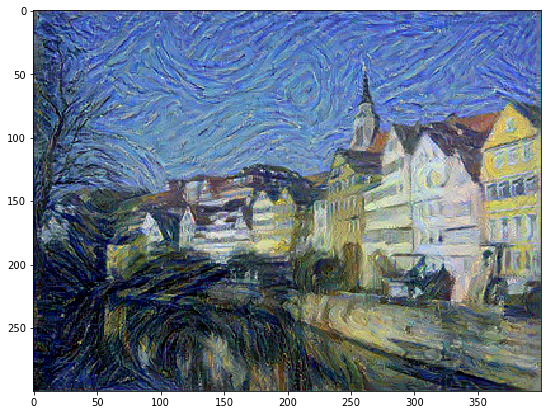

In [62]:
lr=1.
maxiter=500

opt=optim.LBFGS([x],lr=lr)
niter=0
t0=time()
while niter<maxiter:
    def closure():
        global niter
        niter+=1
        opt.zero_grad()
        grams=getgrams(x)
        loss=getloss(grams,stylegrams)
        print(niter,loss.item())
        loss.backward()
        if niter%100==0: print(time()-t0,'s')
        return loss
    opt.step(closure)

print('total time',time()-t0,'s')
plt.figure(figsize=(10,7))
plt.imshow(postp(x))